In [1]:
import findspark
findspark.init()

import time as t
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.streaming import StreamingContext
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta, date
import sys
from lib import sparkStructuredStreaming
import os
%matplotlib inline
from matplotlib import pyplot as plt
from pyspark.sql.window import Window
import math as m
import pandas as pd

### Set-up to stream from Kafka topic + read and write from/to Elasticsearch

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5,org.elasticsearch:elasticsearch-spark-20_2.11:7.6.2 pyspark-shell'

In [3]:
#"127.0.0.1:9092" (local) //"10.0.0.8:9092" (BACC)
bootstrap = "127.0.0.1:9092"

In [4]:
spark = SparkSession \
            .builder \
            .appName("KafkaIEXStructuredStreamingRobovisor") \
            .master("local[*]") \
            .getOrCreate()

sqlContext = SQLContext(spark)

## 1. Backtesting

### 1.1 Try different strategies

In [ ]:
b = sparkStructuredStreaming.backtest()

#strategy looks at last 10,120,500... minutes to calculate average
strategy_momentum = ["momentum",10,30,60]
# mean reverse strategy
rsi_buy = 15
rsi_sell = 60
ibr_buy = 0.2
ibr_sell = 0.7 
strategy_mean_reverse = ["mean_reverse",rsi_buy,rsi_sell,ibr_buy,ibr_sell,3,5,8,10,14,20]
# granularity of historical data
interval_momentum="1m"
interval_mean_reverse = "1d"
hdfs_path = "hdfs://0.0.0.0:19000"
#start capital
startCap = 10000.0
startCap_market = startCap
# regulatory trading fee
commission = 0.006
# risk free market return, assumed here 0.1% but is not really clear
risk_free = 0.001
# parameters to find stock symbols
n_stock = [2,5,10]
start = date(2020,5,27)
end = date(2020,5,28)
period = [1,2,3]
best_of = 5
    
"""while(start+timedelta(days=4)<=end):
    b.full_backtest(startCap, startCap_market, commission, risk_free, strategy_momentum, interval_momentum, start, start + timedelta(days=4), period, n_stock, hdfs_path, sqlContext, best_of, "ml_full")
    start += timedelta(days=7)"""
    
b.full_backtest(startCap, startCap_market, commission, risk_free, strategy_momentum, interval_momentum, start, end, period, n_stock, hdfs_path, sqlContext, best_of, "static_full")

[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
hdfs_path = "hdfs://0.0.0.0:19000"
performance_best = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_best").orderBy(F.col("Start-Date"))
performance_best.show(200)

+-------+-------+-----+----+-------------+-------+----------+----------+------+--------------------+------------------+------------+--------------------+
|DepotId|  Value|Alpha|Beta|Start-Capital| Profit|Start-Date|  End-Date|Trades|Performance_Strategy|Performance_S&P500|Value_S&P500|Start-Capital_S&P500|
+-------+-------+-----+----+-------------+-------+----------+----------+------+--------------------+------------------+------------+--------------------+
|      1|9650.34|-2.95|1.24|      10000.0|-349.66|2020-05-28|2020-05-28|   717|                -3.5|             -0.44|      9956.0|             10000.0|
+-------+-------+-----+----+-------------+-------+----------+----------+------+--------------------+------------------+------------+--------------------+



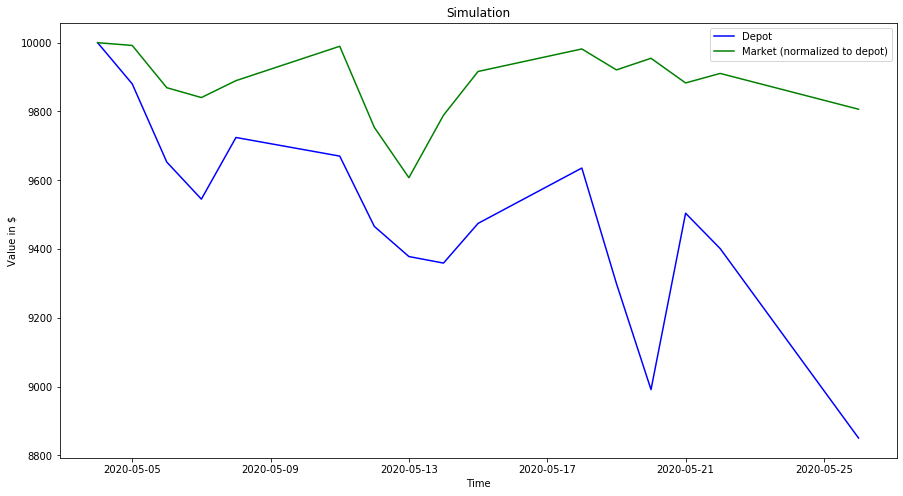

In [15]:
#performance_best_ml = performance_best_ml.collect()
n = len(performance_best_ml)
start_vals_ml = performance_best_ml[0]
date_list = [start_vals_ml['Start-Date']-timedelta(days=1)]

performance_ml = [start_vals_ml['Start-Capital']]
performance_snp = [start_vals_ml['Start-Capital_S&P500']]

for row in performance_best_ml:
    date_list.append(row['Start-Date'])
    performance_ml.append(row["Value"])
    performance_snp.append(row["Value_S&P500"])   

plt.figure(figsize=[15,8])

plt.plot(date_list,performance_ml,'b',label="Depot")
plt.plot(date_list,performance_snp,'g', label="Market (normalized to depot)")
plt.xlabel("Time")
plt.ylabel("Value in $")
plt.legend()
plt.title("Simulation")
plt.show()

In [9]:
depot_best_ml = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/depot_best").orderBy(F.col("DepotId"))
depot_best_ml.show(10, truncate=False)

+-------+-------------+----------+------------------------------------------------+------------------------------------------------------------+---------------+
|DepotId|Start-Capital|Strategy  |ISIN                                            |Share                                                       |Symbol_Strategy|
+-------+-------------+----------+------------------------------------------------+------------------------------------------------------------+---------------+
|1      |10000.0      |momentum60|[M, GPS, KSS, JWN, NCLH, RCL, DFS, SYF, RF, PVH]|[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.05, 0.04, 0.02]|[1, 2]         |
+-------+-------------+----------+------------------------------------------------+------------------------------------------------------------+---------------+



In [17]:
df = pd.read_csv("symbols/constituents.csv", index_col='Symbol')
depot_best_c = depot_best_ml.collect()

name = {}
sector = {}
date = 27
for row in depot_best_c:
    name["2020-05-"+str(date)] = (df[df.index.isin(row.ISIN)]['Name']).tolist()
    sector["2020-05-"+str(date)] = (df[df.index.isin(row.ISIN)]['Sector']).tolist()
    date += 1

In [18]:
name

{'2020-05-27': ['Alliance Data Systems',
  'American Airlines Group',
  'Arconic Inc.',
  'Goodyear Tire & Rubber',
  'L Brands Inc.',
  "Macy's Inc.",
  'Norwegian Cruise Line',
  'PVH Corp.',
  'Royal Caribbean Cruises Ltd',
  'United Continental Holdings'],
 '2020-05-28': ['Alliance Data Systems',
  'American Airlines Group',
  'Discover Financial Services',
  'Gap Inc.',
  "Kohl's Corp.",
  "Macy's Inc.",
  'Nordstrom',
  'Norwegian Cruise Line',
  'PVH Corp.',
  'Royal Caribbean Cruises Ltd',
  'TripAdvisor'],
 '2020-05-29': ['Alexion Pharmaceuticals',
  'Discover Financial Services',
  'Dollar Tree',
  'Gap Inc.',
  'Lockheed Martin Corp.',
  "Macy's Inc.",
  'NextEra Energy',
  'Nordstrom',
  'Synchrony Financial',
  'Tractor Supply Company',
  'TransDigm Group']}

In [12]:
sector

{'2020-05-18': ['Energy', 'Energy'],
 '2020-05-19': ['Consumer Staples', 'Health Care'],
 '2020-05-20': ['Information Technology', 'Utilities'],
 '2020-05-21': ['Information Technology', 'Information Technology'],
 '2020-05-22': ['Utilities', 'Information Technology'],
 '2020-05-23': ['Consumer Discretionary', 'Consumer Discretionary'],
 '2020-05-24': ['Financials',
  'Financials',
  'Energy',
  'Financials',
  'Health Care'],
 '2020-05-25': ['Health Care', 'Energy'],
 '2020-05-26': ['Utilities',
  'Consumer Staples',
  'Consumer Staples',
  'Materials',
  'Health Care'],
 '2020-05-27': ['Financials',
  'Industrials',
  'Information Technology',
  'Consumer Discretionary',
  'Real Estate'],
 '2020-05-28': ['Financials', 'Industrials'],
 '2020-05-29': ['Consumer Discretionary', 'Industrials']}

In [17]:
performance_full_ml = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_full_ml/20200505").orderBy(F.col("Performance_Strategy").desc())
performance_full_ml.show(100)

+-------+--------+-----+----+-------------+-------+----------+----------+------+--------------------+------------------+------------+--------------------+
|DepotId|   Value|Alpha|Beta|Start-Capital| Profit|Start-Date|  End-Date|Trades|Performance_Strategy|Performance_S&P500|Value_S&P500|Start-Capital_S&P500|
+-------+--------+-----+----+-------------+-------+----------+----------+------+--------------------+------------------+------------+--------------------+
|     76|10302.87| 3.11|1.05|      10000.0| 302.87|2020-05-05|2020-05-05|     5|                3.03|             -0.08|      9992.0|             10000.0|
|     80|10302.87| 3.11|1.05|      10000.0| 302.87|2020-05-05|2020-05-05|     5|                3.03|             -0.08|      9992.0|             10000.0|
|     56|10289.36| 2.96|0.83|      10000.0| 289.36|2020-05-05|2020-05-05|     4|                2.89|             -0.08|      9992.0|             10000.0|
|     64|10289.36| 2.96|0.83|      10000.0| 289.36|2020-05-05|2020-05-

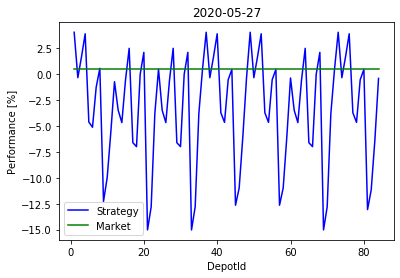

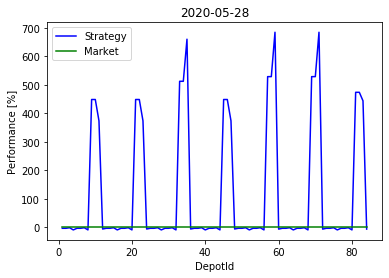

In [15]:
i = 0

for day in ["27", "28"]:
    
    performance_full_ml = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_full_ml/202005"+day).orderBy(F.col("DepotId")).collect()
    n = len(performance_full_ml)
    depotId = [i+1 for i in range(n)]
    performance_str = []
    performance_snp = []

    for row in performance_full_ml:
        performance_str.append(row["Performance_Strategy"])
        performance_snp.append(row["Performance_S&P500"])
        
    plt.plot(depotId,performance_str,'b',label="Strategy")
    plt.plot(depotId,performance_snp,'g', label="Market")
    plt.xlabel("DepotId")
    plt.ylabel("Performance [%]")
    plt.legend()
    plt.title("2020-05-"+day)
    plt.show()

In [10]:
hdfs_path = "hdfs://0.0.0.0:19000"
depot_full_ml = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/ml")
depot_full_ml.show(100, truncate=False)

AnalysisException: 'Path does not exist: hdfs://0.0.0.0:19000/backtest/ml;'

## 2. Trading Simulation / Performance Evaluation with realtime Streams (Spark Streaming)

### Stream real time quotes from Kafka topic

In [ ]:
r = sparkStructuredStreaming.realtime()
day = date(2020,5,5)
sandbox = True
commission = 0.006
startCap = 10000.0

r.realtime(startCap, day, sandbox, commission, sqlContext)